# Subject exploration
___

This notebook aims to explore, verify and add useful information to the subject informations. We will look at the provided information in the `SC_subjects.csv`, the information contained in the recording's headers and to the hypnograms. It will allow us to see the different sleep characteristics of the patients.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Ensure parent folder is in PYTHONPATH
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import pandas as pd
import mne 
import numpy as np
from seaborn import regplot
from importlib import reload

from utils import (fetch_data, AGE_SLEEP_RECORDS)
from constants import (SLEEP_STAGES_VALUES,
                       N_STAGES,
                       DATASET_SLEEP_STAGES_VALUES)

In [3]:
ALL_DATASET_SLEEP_STAGE_VALUES = {
    **DATASET_SLEEP_STAGES_VALUES,
    'Sleep stage ?': -1,
    'Movement time': -1
}

WAKE_STAGE = ['Sleep stage W', 'Sleep stage ?', 'Movement time']
SUBJECTS = range(83)
NIGHTS = [1,2]

In [4]:
subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHTS, local_data_path=f"../{AGE_SLEEP_RECORDS}")

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [5]:
df_subject_information = pd.read_csv("../data/SC-subjects.csv", delimiter=';')
df_subject_information = df_subject_information.rename(columns={"sex (F=1)": "sex"}, errors="raise")
df_subject_information['LightsOff'] =  pd.to_datetime(df_subject_information['LightsOff'], format='%H:%M')
df_subject_information.head(5)

,subject,night,age,sex,LightsOff
0,0,1,33,1,1900-01-01 00:38:00
1,0,2,33,1,1900-01-01 21:57:00
2,1,1,33,1,1900-01-01 22:44:00
3,1,2,33,1,1900-01-01 22:15:00
4,2,1,26,1,1900-01-01 22:50:00


## Lights off onset
___

We initially just have the **local start date and local lights off time**. Start date can be found in the recording file's headers, whereas the local lights off times are located in a separate file. Both will be saved in another file, to be later used in the pipeline.

Currently there is **153 night recordings** coming from 82 subjects. Because we have a limited capacity in terms of memory, we will have to discard some part of the recorded signal. As we've seen in the previous section, files contain a whole day of recording (a little bit less than 24 hours).

Then, all the signal before the subject turned the lights off and after the subject has awaken in the morning is discarded. We still must analyze how many hours of recording we will have left.

We will keep this information in our dataframe, where we define **NightDuration** as the timespan, in seconds, inbetween the time at which the subject closed the lights and the time at which the subject had their last non-wake sleep stage scored.

#### Define Lights off onset
___

We were not able to find any documentation about the used timezone. Therefore, we will assume it is expressed in a UTC time format.

In [6]:
def get_lights_off(raw_data_info, file_index):
    """
    Returns a tuple in which there are:
        - the duration (in seconds) between the beginning of the recording and the time
            at which the subject turned off the lights.
        - the datetime at which the lights were turned off
    """

    raw_data_start_time = datetime.utcfromtimestamp(raw_data_info['meas_date'][0])
    raw_data_lights_off_time = df_subject_information.loc[file_index, 'LightsOff']
    
    if raw_data_lights_off_time.time().hour < 12: # Fallen asleep after midnight
        lightoff_date = raw_data_start_time.date() + timedelta(days=1)
    else:                                         # Fallen asleep before midnight
        lightoff_date = raw_data_start_time.date()
        
    raw_data_lights_off_time = raw_data_lights_off_time.replace(year=lightoff_date.year, month=lightoff_date.month, day=lightoff_date.day)

    return ((raw_data_lights_off_time - raw_data_start_time).total_seconds(), raw_data_lights_off_time)

#### Define woke up offset
___

Here, we consider that the subject woke up at the last non-wake stage. It can lead to errors in some cases, because some people might have woken up in the morning, then take a nap later.

In [7]:
def find_last_non_wake_annotation(annotations, timestamps):
    scores_with_timestamp = list(zip(annotations, timestamps))

    return next(
        (time for (stage, time) in reversed(scores_with_timestamp) if stage not in WAKE_STAGE),
        None)


#### Night duration
___

In [8]:

for file_index in range(len(subject_files)):

    data = mne.io.read_raw_edf(subject_files[file_index][0], preload=False, verbose=False)
    data.set_annotations(mne.read_annotations(subject_files[file_index][1]), emit_warning=False)
    
    start_time_timestamp = data.info['meas_date'][0]
    light_off_seconds, light_off_time = get_lights_off(data.info, file_index)
    last_non_wake_seconds = find_last_non_wake_annotation(data.annotations.description, data.annotations.onset)
    
    assert (last_non_wake_seconds - light_off_seconds) % 30 == 0, "Must respect epoch size"
    
    df_subject_information.loc[file_index, 'NightDuration'] = last_non_wake_seconds - light_off_seconds
    df_subject_information.loc[file_index, 'LightsOff'] = light_off_time
    df_subject_information.loc[file_index, 'LightsOffSecond'] = light_off_seconds
    df_subject_information.loc[file_index, 'StartRecord'] = datetime.utcfromtimestamp(start_time_timestamp)
    df_subject_information.loc[file_index, 'StartRecordTimestamp'] = start_time_timestamp
    
    del data

df_subject_information.head(5)

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp
0,0,1,33,1,1989-04-25 00:38:00,21810.0,30300.0,1989-04-24 16:13:00,609437580.0
1,0,2,33,1,1989-04-25 21:57:00,30330.0,25620.0,1989-04-25 14:50:00,609519000.0
2,1,1,33,1,1989-03-29 22:44:00,29250.0,21300.0,1989-03-29 16:49:00,607193340.0
3,1,2,33,1,1989-03-30 22:15:00,31260.0,18900.0,1989-03-30 17:00:00,607280400.0
4,2,1,26,1,1989-04-05 22:50:00,27150.0,21720.0,1989-04-05 16:48:00,607798080.0


#### Exploring night duration and lights off
___

In [9]:
print(f"Hours of recording: {df_subject_information['NightDuration'].sum()/3600:.3f}")
print(f"Nb of 30s epochs: {df_subject_information['NightDuration'].sum()/30}")

Hours of recording: 1335.792
Nb of 30s epochs: 160295.0


We then check if any file contains unusual information.

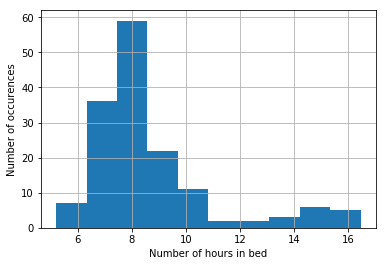

In [10]:
plt.xlabel("Number of hours in bed")
plt.ylabel("Number of occurences")
plt.grid(b=True)
plt.hist([x/3600 for x in df_subject_information['NightDuration']]);

We can see that, as expected, some people spent an unsually high amount of time in bed, whereas the span between the last non wake stage and the light off mark. This can be explained by the fact that some people may have taken a nap the following day.


[]

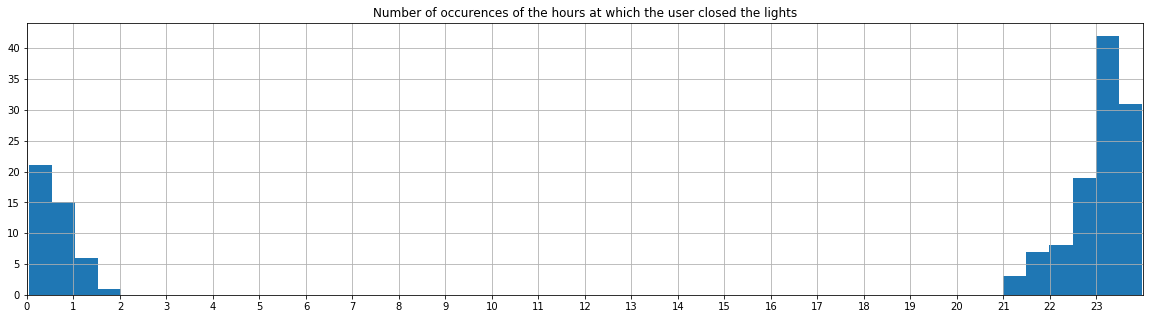

In [11]:
lights_off = df_subject_information['LightsOff']
night_duration = df_subject_information['NightDuration']

plt.figure(figsize=(20, 5))
plt.title("Number of occurences of the hours at which the user closed the lights")
plt.xlim(0, 24)
plt.xticks(range(24))
plt.grid(b=True)
plt.hist(x=[h for h in lights_off.dt.hour + lights_off.dt.minute/60], bins=48)

plt.plot()

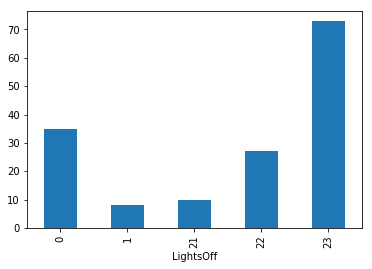

In [12]:
df_subject_information.groupby(df_subject_information["LightsOff"].dt.hour).count()["LightsOff"].plot(kind="bar")

The earliest time at which a subject went to sleep is at about 10 o'clock and the later time at which a subject went to sleep is at about 1:45.

All of the processed information looks good.

In [13]:
df_subject_information.to_csv("../data/recordings-info.csv", index=False)

## Sleep Characteristics
___


#### Define sleep characteristics
___

In [14]:
def get_sleep_stage_at_offset(annotations, offset):
    """Returns the sleep stage at the specified onset.
    Input
    -------
    annotations: List of OrderedDicts, as returned by the `mne.read_annotations` function
    onset: Time since the start of the recording in seconds.

    Returns
    -------
    Sleep stage: str
    """
    return annotations[
        next(idx for idx, elem in enumerate(annotations) if elem['onset'] > offset) - 1
    ]['description']

def get_sleep_latency(annotations, lights_off_onset):
    """Returns the sleep latency
    Input
    -------
    annotations: List of OrderedDicts, as returned by the `mne.read_annotations` function
    lights_off_onset: Span between the time the record started and the lights were turned off

    Returns
    -------
    Span, in seconds, between the time lights were turned off the first non sleep stage
    """
    fell_asleep_onset = annotations[
        next(
            idx for idx, elem in enumerate(annotations) if elem['onset'] > lights_off_onset and elem['description'] not in WAKE_STAGE)
    ]['onset']
    return fell_asleep_onset - lights_off_onset
    

#### Calculate sleep characteristics
___

In [15]:

for i in range(len(df_subject_information)):
    annotations = mne.read_annotations(subject_files[i][1])
    lights_off_onset = df_subject_information.loc[i, 'LightsOffSecond'] 

    df_subject_information.loc[i, 'SleepLatency'] = get_sleep_latency(annotations, lights_off_onset)
    df_subject_information.loc[i, 'SleepStageAtLightsOff'] = get_sleep_stage_at_offset(annotations, lights_off_onset)
    df_subject_information.loc[i, 'TotalSleptTime'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] not in WAKE_STAGE])
    df_subject_information.loc[i, 'TotalN1'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage 1'])
    df_subject_information.loc[i, 'TotalN2'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage 2'])
    df_subject_information.loc[i, 'TotalN3'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] in ['Sleep stage 3', 'Sleep stage 4']])
    df_subject_information.loc[i, 'TotalR'] = np.sum([annotation['duration'] for annotation in annotations if annotation['description'] == 'Sleep stage R'])
    df_subject_information.loc[i, 'NbTransitionStade'] = len([annotation for annotation in annotations if annotation['description'] not in ['Sleep stage ?', 'Movement time']])

df_subject_information.head(5)

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp,SleepLatency,SleepStageAtLightsOff,TotalSleptTime,TotalN1,TotalN2,TotalN3,TotalR,NbTransitionStade
0,0,1,33,1,1989-04-25 00:38:00,21810.0,30300.0,1989-04-24 16:13:00,609437580.0,330.0,Sleep stage W,19590.0,1740.0,7500.0,6600.0,3750.0,153.0
1,0,2,33,1,1989-04-25 21:57:00,30330.0,25620.0,1989-04-25 14:50:00,609519000.0,450.0,Sleep stage W,28320.0,1770.0,11190.0,8910.0,6450.0,150.0
2,1,1,33,1,1989-03-29 22:44:00,29250.0,21300.0,1989-03-29 16:49:00,607193340.0,240.0,Sleep stage W,28380.0,3270.0,16860.0,3150.0,5100.0,125.0
3,1,2,33,1,1989-03-30 22:15:00,31260.0,18900.0,1989-03-30 17:00:00,607280400.0,390.0,Sleep stage W,30720.0,2760.0,19800.0,2880.0,5280.0,170.0
4,2,1,26,1,1989-04-05 22:50:00,27150.0,21720.0,1989-04-05 16:48:00,607798080.0,150.0,Sleep stage W,26910.0,2820.0,16350.0,2850.0,4890.0,160.0


#### Verify sleep stage at lights off
___

In [16]:
df_subject_information[df_subject_information['SleepStageAtLightsOff'] != 'Sleep stage W']

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp,SleepLatency,SleepStageAtLightsOff,TotalSleptTime,TotalN1,TotalN2,TotalN3,TotalR,NbTransitionStade
24,12,1,26,2,1989-05-23 00:50:00,25050.0,31680.0,1989-05-22 16:02:00,611856120.0,900.0,Sleep stage 2,26280.0,1440.0,13890.0,3210.0,7740.0,127.0
66,33,2,60,2,1990-03-20 22:55:00,24660.0,27300.0,1990-03-20 15:20:00,637946400.0,330.0,Sleep stage 2,26310.0,2730.0,19440.0,0.0,4140.0,112.0
93,48,2,67,1,1990-07-14 23:57:00,53490.0,29220.0,1990-07-14 15:50:00,647970600.0,240.0,Sleep stage 1,28260.0,4380.0,15600.0,3480.0,4800.0,207.0
118,61,2,101,1,1989-09-08 01:00:00,24810.0,36000.0,1989-09-07 15:00:00,621183600.0,330.0,Sleep stage R,25620.0,2880.0,14370.0,1950.0,6420.0,152.0
119,62,1,95,1,1989-11-21 21:00:00,38580.0,16440.0,1989-11-21 16:26:00,627668760.0,990.0,Sleep stage 2,33390.0,8280.0,22350.0,420.0,2340.0,189.0
120,62,2,95,1,1989-11-23 21:00:00,51060.0,23160.0,1989-11-23 14:34:00,627834840.0,210.0,Sleep stage 1,26910.0,10410.0,12930.0,120.0,3450.0,195.0
125,65,1,88,1,1989-11-06 23:10:00,45600.0,31500.0,1989-11-06 14:25:00,626365500.0,240.0,Sleep stage 2,36600.0,3000.0,24630.0,4200.0,4770.0,250.0
133,71,1,88,2,1989-09-26 21:15:00,37590.0,20400.0,1989-09-26 15:35:00,622827300.0,270.0,Sleep stage 1,28830.0,7020.0,18150.0,120.0,3540.0,127.0
149,81,1,57,1,1991-09-23 22:00:00,28740.0,24180.0,1991-09-23 15:17:00,685639020.0,270.0,Sleep stage 2,27990.0,2640.0,15840.0,3630.0,5880.0,224.0


We can see that some subjects are already alseep at the moment they marked they closed the lights. We do not know why it is the case... We will mark these subject as "problematics"

In [17]:
problematic_subject = df_subject_information[df_subject_information['SleepStageAtLightsOff'] != 'Sleep stage W']

In [18]:
def print_hypnogram(annotations, title, lights_off_seconds=None):
    hypnogram_x = [onset for onset in annotations.onset for _ in (0, 1)][1:]
    hypnogram_y = [ALL_DATASET_SLEEP_STAGE_VALUES[stage] for stage in annotations.description for _ in (0, 1)][:-1]
    
    plt.rcParams["figure.figsize"] = (20,5)
    plt.gca().invert_yaxis()
    plt.plot(hypnogram_x, hypnogram_y)
    
    if lights_off_seconds is not None:
        plt.axvline(lights_off_seconds, color='r')
    
    plt.title(title)
    plt.xlabel("Onset (seconds)")
    plt.ylabel("Sleep stage")
    plt.show()

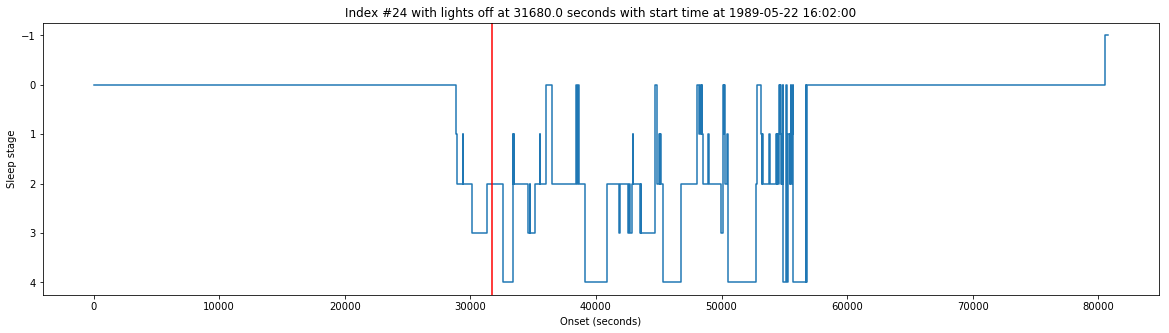

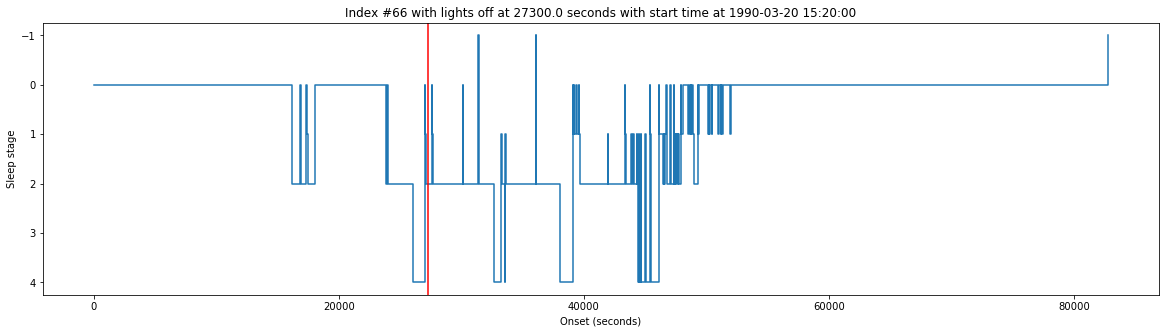

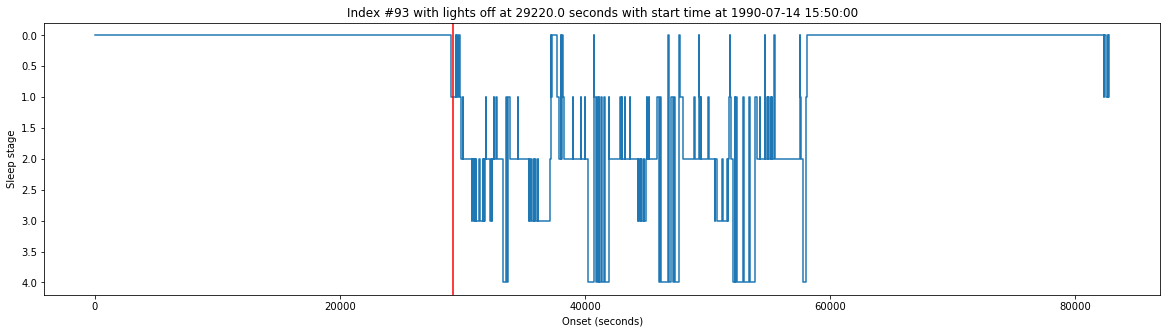

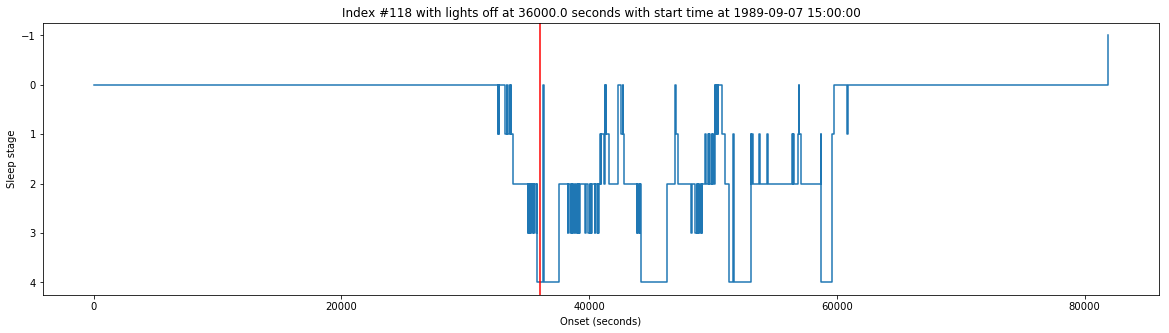

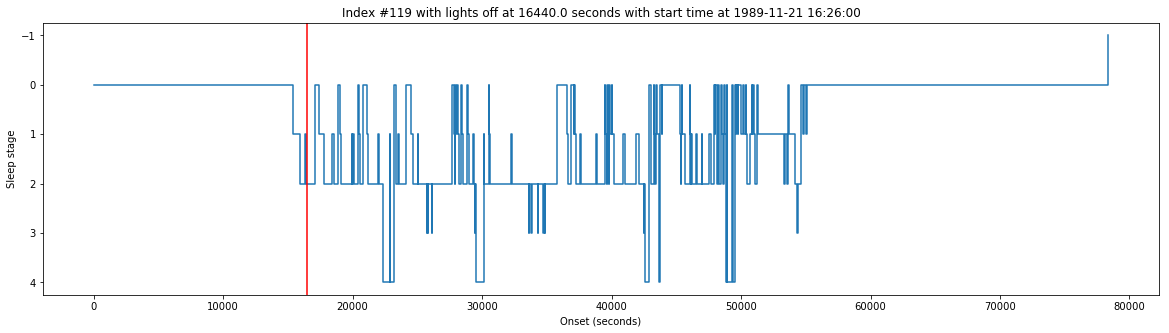

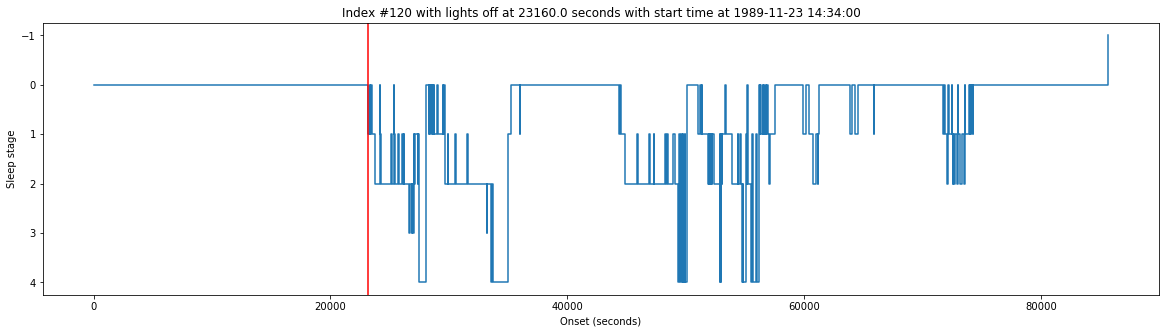

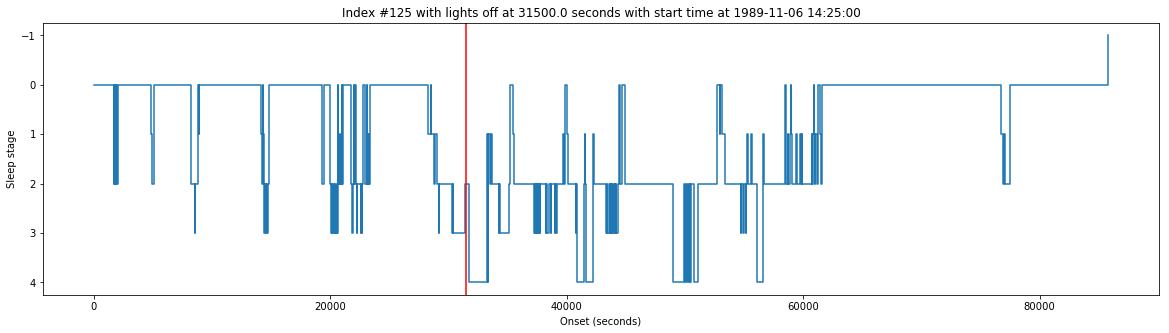

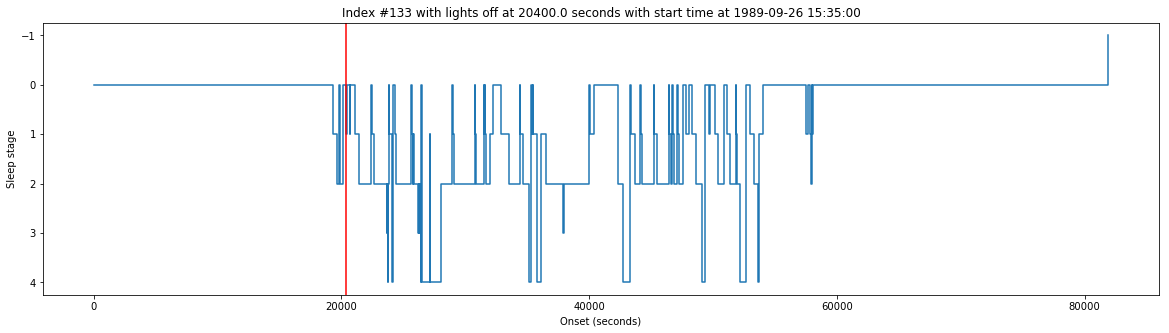

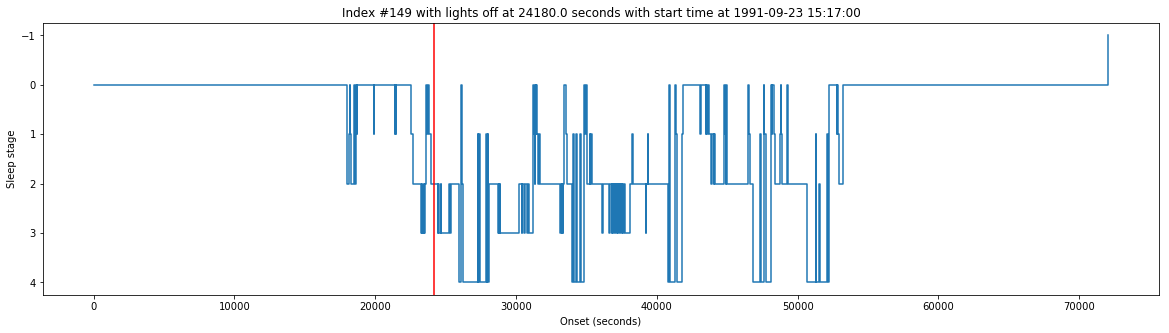

In [19]:
for subject_idx in problematic_subject.index:
    annotations = mne.read_annotations(subject_files[subject_idx][1])
    info = df_subject_information.iloc[subject_idx]
    print_hypnogram(
        annotations,
        f"Index #{subject_idx} with lights off at {info['LightsOffSecond']} seconds with start time at {info['StartRecord']}",
        info['LightsOffSecond'])

If we want to calculate mean sleep characteristics, we have to exclude those, because they do not start at the right time.

#### Verify sleep latency
___

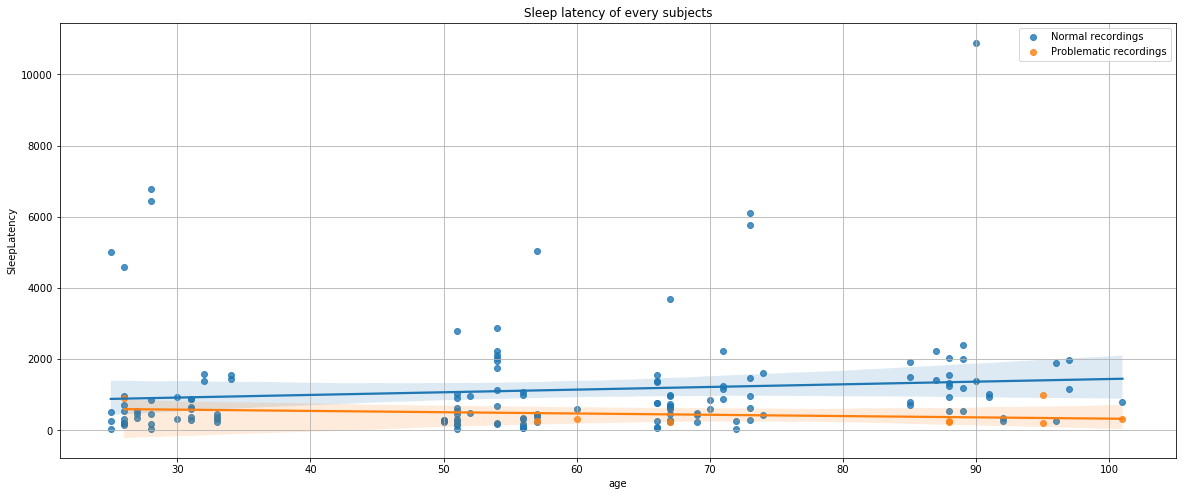

In [20]:
plt.figure(figsize=(20,8))
plt.title('Sleep latency of every subjects')
plt.grid(True)
regplot(x='age', y='SleepLatency', data=df_subject_information[~df_subject_information.isin(problematic_subject)], label='Normal recordings')
regplot(x='age', y='SleepLatency', data=problematic_subject, label='Problematic recordings')
plt.legend()


#### Verify night duration
___

In [21]:
sleepy_subjects = df_subject_information[df_subject_information['NightDuration'] > 3600*12]
print("Number of subjects that slept a lot: ", len(sleepy_subjects))
sleepy_subjects.head(5)

Number of subjects that slept a lot:  16


,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp,SleepLatency,SleepStageAtLightsOff,TotalSleptTime,TotalN1,TotalN2,TotalN3,TotalR,NbTransitionStade
46,23,2,50,1,1989-06-30 00:32:00,48690.0,28620.0,1989-06-29 16:35:00,615141300.0,300.0,Sleep stage W,24390.0,11460.0,6390.0,30.0,6510.0,142.0
65,33,1,60,2,1990-03-19 22:58:00,53610.0,27780.0,1990-03-19 15:15:00,637859700.0,600.0,Sleep stage W,24990.0,6360.0,13590.0,0.0,5040.0,120.0
91,47,2,73,1,1990-03-15 22:25:00,54570.0,26400.0,1990-03-15 15:05:00,637513500.0,960.0,Sleep stage W,21720.0,4830.0,8970.0,4320.0,3600.0,229.0
92,48,1,67,1,1990-07-13 23:04:00,58590.0,26940.0,1990-07-13 15:35:00,647883300.0,450.0,Sleep stage W,33030.0,8970.0,14130.0,2850.0,7080.0,218.0
93,48,2,67,1,1990-07-14 23:57:00,53490.0,29220.0,1990-07-14 15:50:00,647970600.0,240.0,Sleep stage 1,28260.0,4380.0,15600.0,3480.0,4800.0,207.0


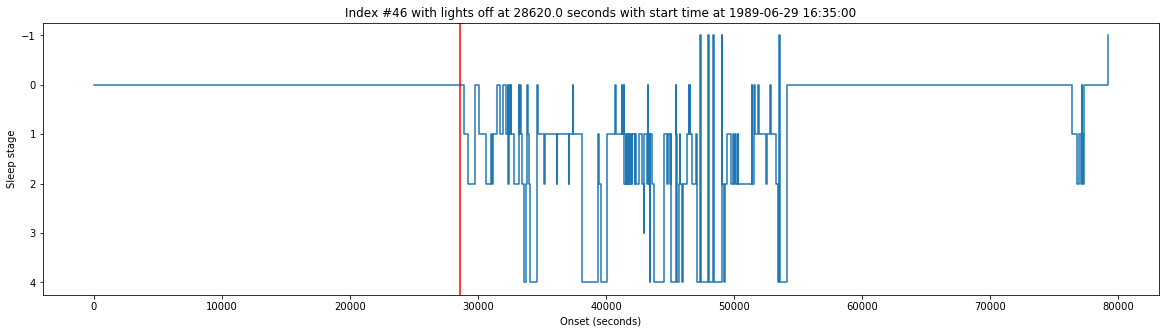

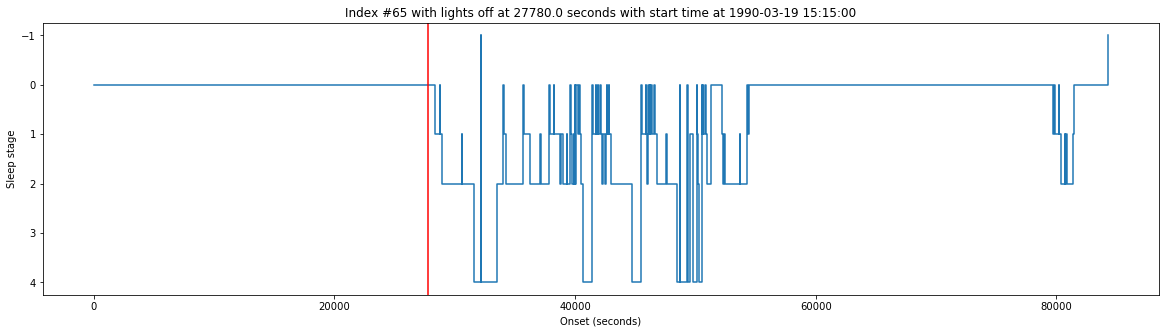

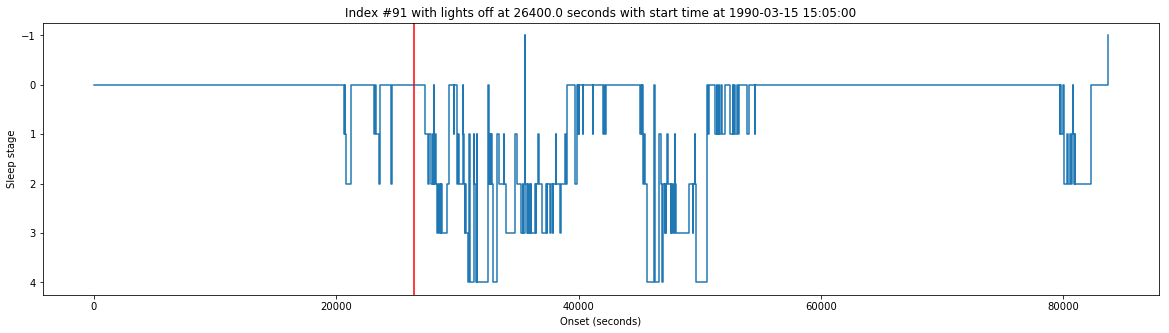

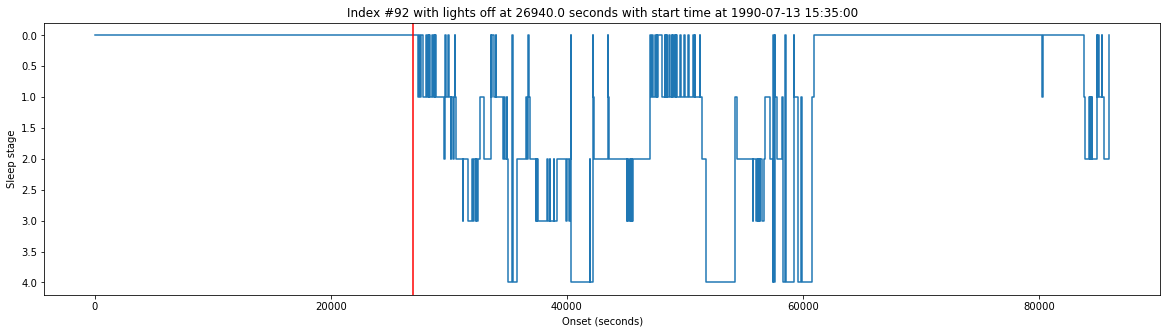

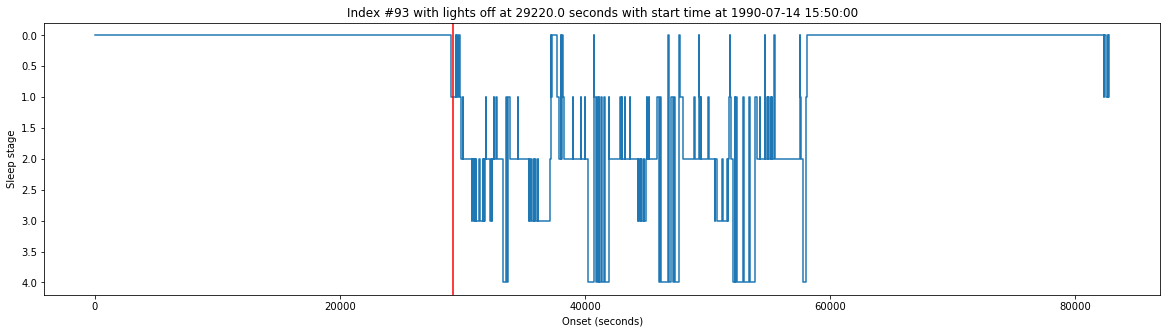

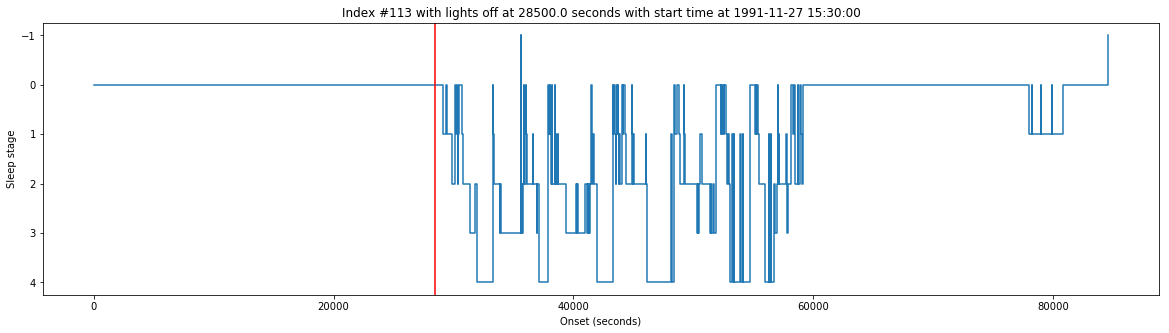

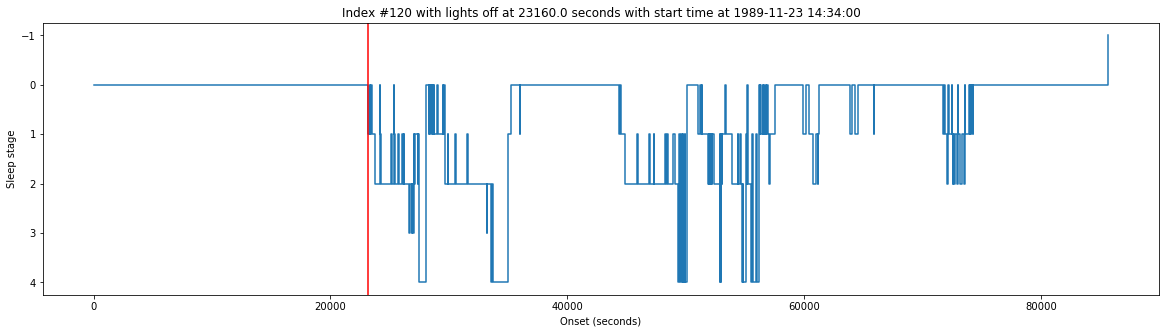

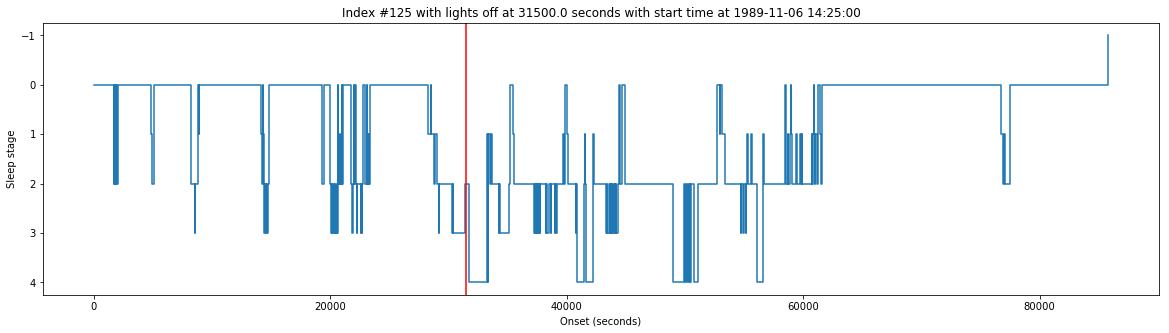

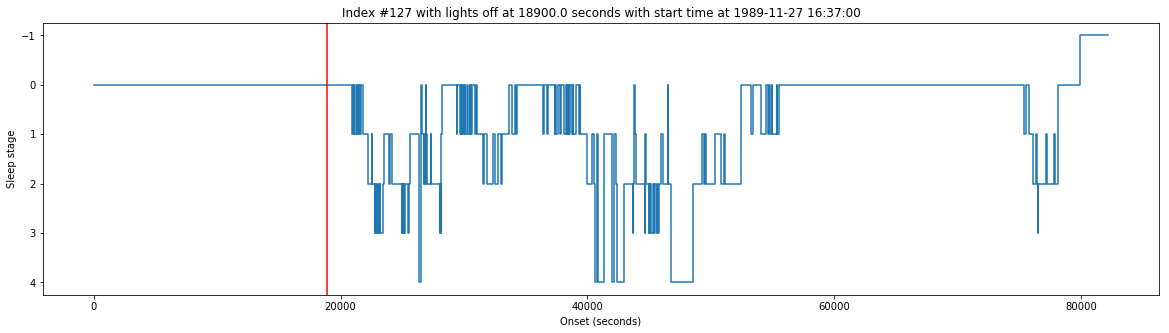

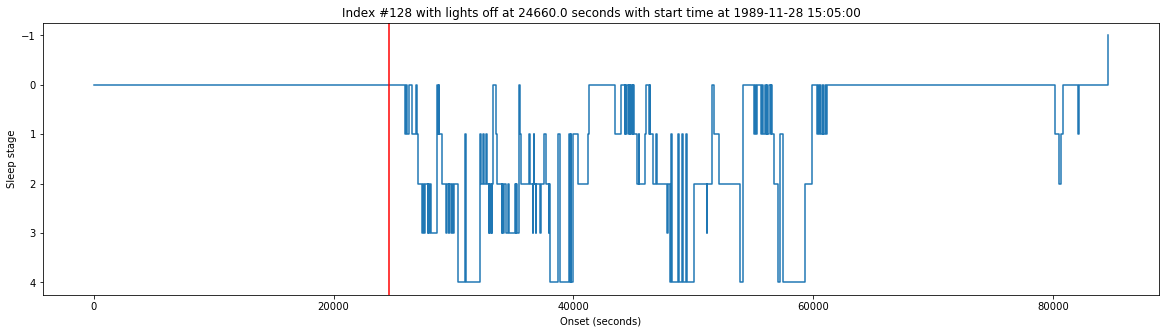

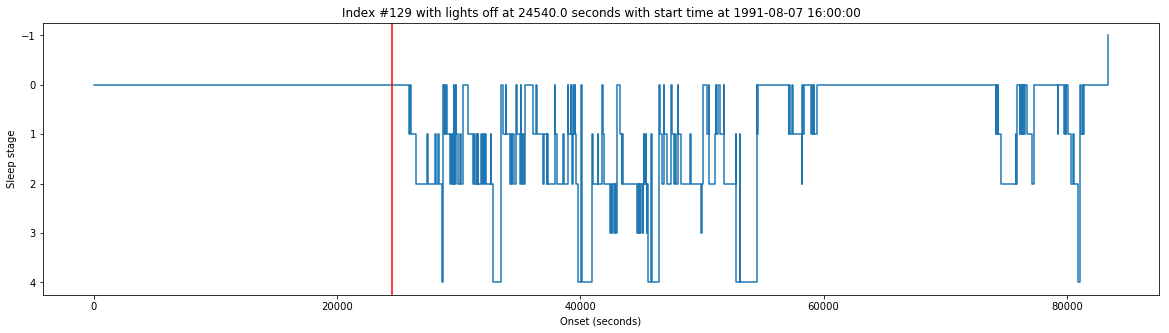

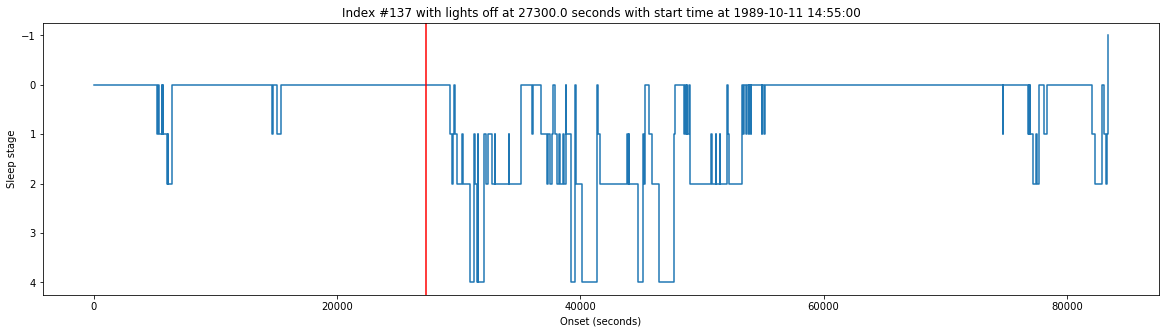

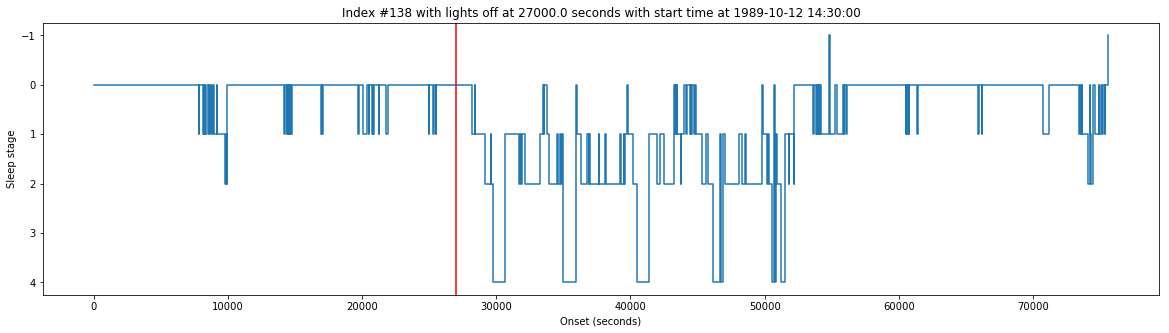

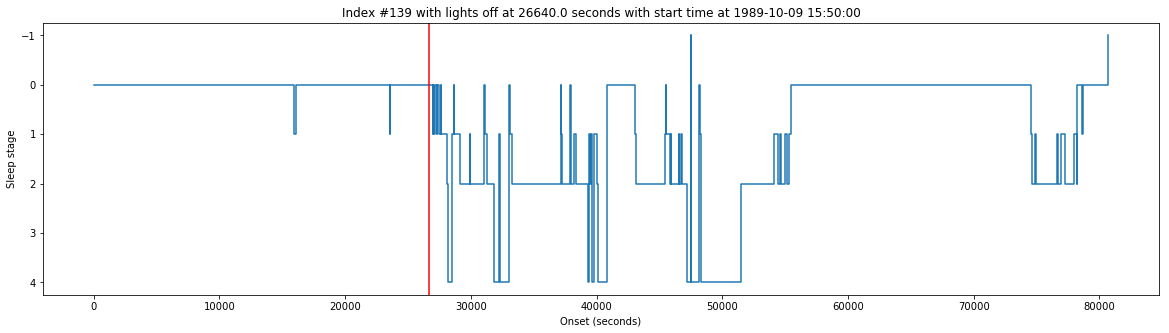

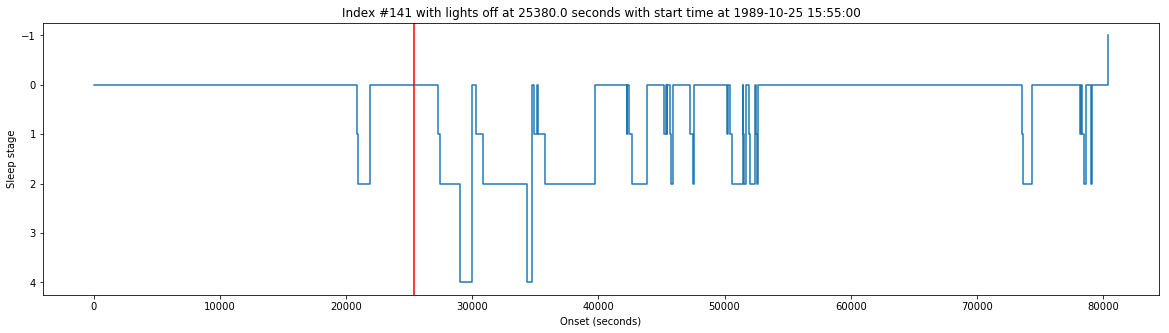

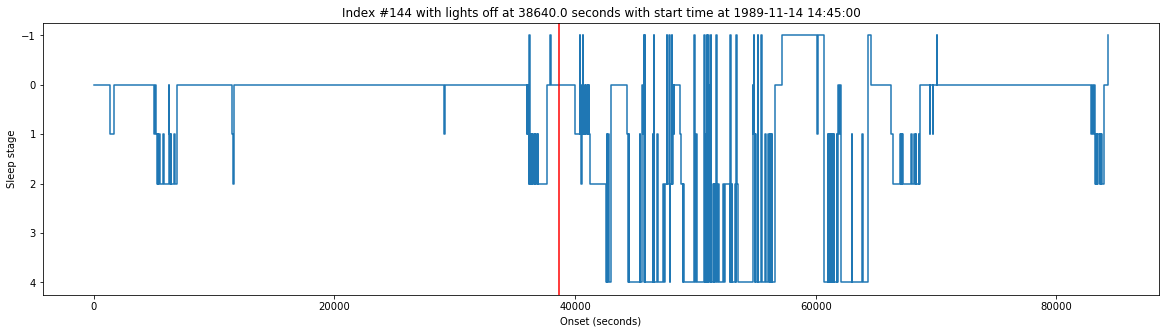

In [22]:
for subject_idx in sleepy_subjects.index:
    annotations = mne.read_annotations(subject_files[subject_idx][1])
    info = df_subject_information.iloc[subject_idx]
    print_hypnogram(
        annotations,
        f"Index #{subject_idx} with lights off at {info['LightsOffSecond']} seconds with start time at {info['StartRecord']}",
        info['LightsOffSecond'])

We see that most people that have a night duration over 12 hours have generally fallen asleep the next day (we can assume they took a nap). If we want to calculcate the mean night duration, we have to consider those.